# iMet Collection 2021 with Lightning ⚡

## Setup environment 

- connect the gDrive with dataset
- extract data to local
- install pytorch lightning

In [1]:
from google.colab import drive
# connect to  my gDrive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# copy the dataset to local drive
#! rsync -ah --progress /content/gdrive/Shareddrives/Datasets/Kaggle/iMet/imet-2021-fgvc8.zip imet.zip

In [3]:
! rm -rf train-1/
! rm -rf test/

# extract dataset to the drive
! unzip /content/gdrive/Shareddrives/Datasets/Kaggle/iMet/imet-2021-fgvc8.zip -d imet-2021-fgvc8 | awk 'BEGIN {ORS=" "} {if(NR%500==0)print "."}'
! ls -l

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . total 12
drwx------ 6 root root 4096 Jun  7 06:41 gdrive
drwxr-xr-x 4 root root 4096 Jun  7 06:59 imet-2021-fgvc8
drwxr-xr-x 1 root root 4096 Jun  1 13:40 sample_data


In [1]:
! pip install -q -U pytorch-lightning torchmetrics
! pip install -q https://github.com/Borda/kaggle_iMet-collection/archive/main.zip

# import os
# os.kill(os.getpid(), 9)
! pip list | grep torch
! pip list | grep kaggle

pytorch-lightning             1.3.4              
torch                         1.8.1+cu101        
torchmetrics                  0.3.2              
torchsummary                  1.5.1              
torchtext                     0.9.1              
torchvision                   0.9.1+cu101        
kaggle                        1.5.12             
kaggle-imet                   0.0.0              


In [2]:
! nvidia-smi

Mon Jun  7 07:11:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Exploration

Checking what data do we have available...

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

PATH_DATASET = "/content/imet-2021-fgvc8/"
pd.read_csv(PATH_DATASET + "train-from-kaggle.csv").head()

,id,attribute_ids
0,000040d66f14ced4cdd18cd95d91800f,448 2429 782
1,0000ef13e37ef70412166725ec034a8a,2997 3231 2730 3294 3099 2017 784
2,0001eeb4a06e8daa7c6951bcd124c3c7,2436 1715 23
3,000226398d224de78b191e6db45fd94e,2997 3433 448 782
4,00029c3b0171158d63b1bbf803a7d750,3465 3322 3170 1553 781


Checkout the label mapping , there seems to be some topics note that country as operand inside AND and OR which would be better encoded with just primitives

In [4]:
df_label_map = pd.read_csv(PATH_DATASET + "label_map.csv", index_col="attribute_id")
print(f"len: {len(df_label_map)}")
print(df_label_map.head())

df_label_map["is_OR"] = ['or' in name for name in df_label_map["attribute_name"]]
df_label_map["is_AND"] = ['and' in name for name in df_label_map["attribute_name"]]
df_label_map["topic"] = [name.split("::")[0] if "::" in name else "." for name in df_label_map["attribute_name"]]
topics = set(df_label_map['topic'])

print(f"include OR: {sum(df_label_map['is_OR'])}")
print(f"include AND: {sum(df_label_map['is_AND'])}")
print(f"topics: {topics}")

len: 3474
                    attribute_name
attribute_id                      
0             country::afghanistan
1                country::alamania
2                 country::algeria
3                  country::arabia
4                 country::armenia
include OR: 480
include AND: 409
topics: {'culture', 'country', 'dimension', 'tags', 'medium'}


Also labeling per image seems to be one to many with multiple same topis per image...

len: 142119
                                 id                      attribute_ids
0  000040d66f14ced4cdd18cd95d91800f                       448 2429 782
1  0000ef13e37ef70412166725ec034a8a  2997 3231 2730 3294 3099 2017 784
2  0001eeb4a06e8daa7c6951bcd124c3c7                       2436 1715 23
3  000226398d224de78b191e6db45fd94e                  2997 3433 448 782
4  00029c3b0171158d63b1bbf803a7d750            3465 3322 3170 1553 781
max lbs: 26
{0: 0, 1: 1795, 2: 11941, 3: 33042, 4: 34967, 5: 28014, 6: 16172, 7: 8908, 8: 4094, 9: 1863, 10: 736, 11: 315, 12: 127, 13: 64, 14: 28, 15: 20, 16: 13, 17: 8, 18: 4, 19: 3, 20: 1, 21: 3, 22: 0, 23: 0, 24: 0}


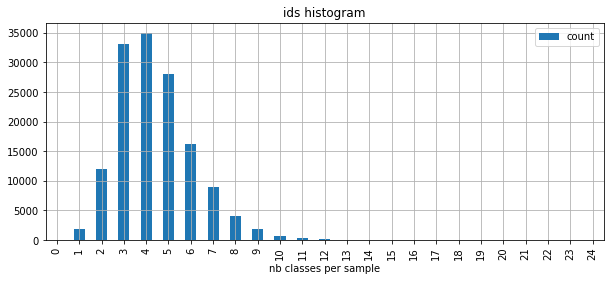

In [ ]:
df_train = pd.read_csv(PATH_DATASET + "train-from-kaggle.csv")
print(f"len: {len(df_train)}")
print(df_train.head())

df_train['nb_classes'] = [len(lbs.split(" ")) for lbs in df_train['attribute_ids']]
lb_hist = dict(zip(range(25), np.bincount(df_train['nb_classes'])))
df_hist = pd.DataFrame([dict(lb=lb, count=count) for lb, count in lb_hist.items()]).set_index("lb")

print(f"max lbs: {max(df_train['nb_classes'])}")
df_hist.plot(kind="bar", grid=True, title="labels combination histogram", xlabel='nb classes per sample', figsize=(10, 4))
print(lb_hist)

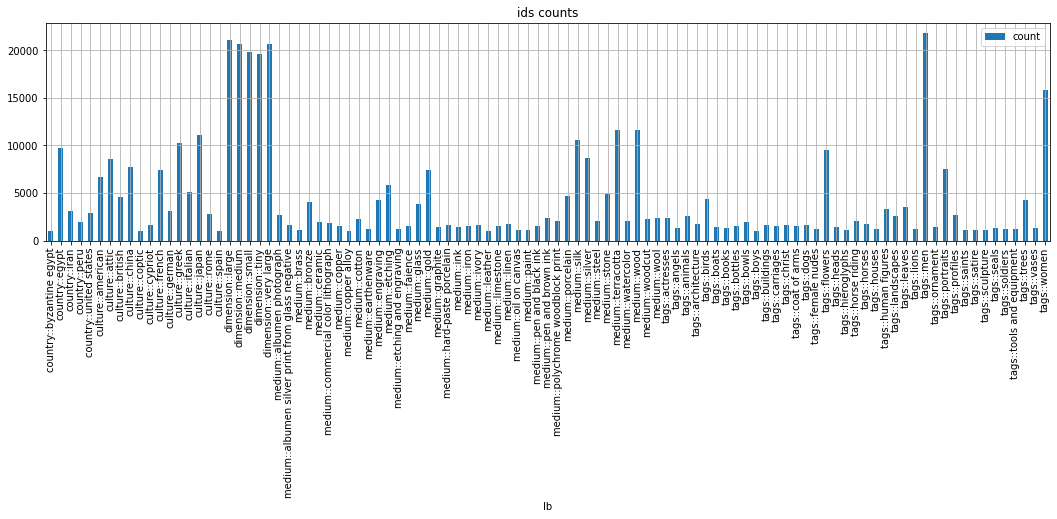

In [ ]:
import itertools

label_map = dict(zip(df_label_map.index, df_label_map['attribute_name']))
COUNT_THR = 1000

labels_all = list(itertools.chain(*[[int(lb) for lb in lbs.split(" ")] for lbs in df_train['attribute_ids']]))
lb_hist = dict(zip(range(max(labels_all) + 1), np.bincount(labels_all)))
df_hist = pd.DataFrame([dict(lb=label_map[lb], count=count) for lb, count in lb_hist.items() if count > COUNT_THR]).set_index("lb")

ax = df_hist.plot(kind="bar", grid=True, title="ids counts", figsize=(18, 4))
# print(lb_hist)

## Dataset & DataModule

Creating standard PyTorch dataset to define how the data shall be loaded and set representations. We define the sample pair as:
- RGB image
- one-hot lable encding

A DataModule standardizes the training, val, test splits, data preparation and transforms. The main advantage is consistent data splits, data preparation and transforms across models.

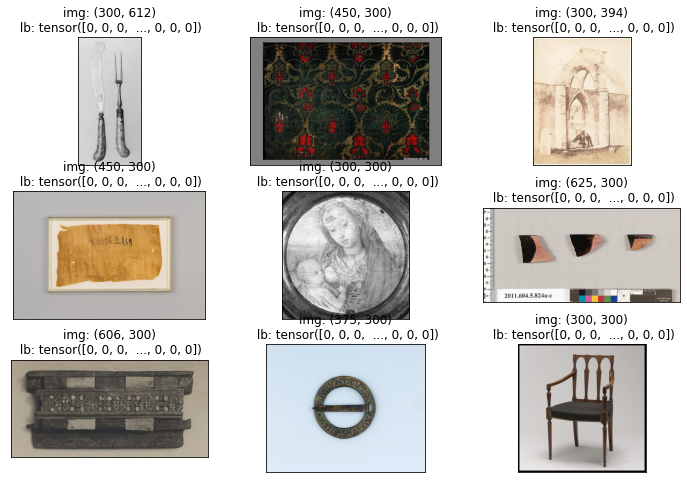

In [ ]:
import matplotlib.pyplot as plt

from kaggle_imet.data import IMetDataset


dataset = IMetDataset(
    df_data=PATH_DATASET + "train-from-kaggle.csv",
    path_img_dir=PATH_DATASET + "train-1/train-1",
)

# quick view
fig = plt.figure(figsize=(12, 8))
for i in range(9):
    img, lb = dataset[i]
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(f"img: {img.size}\n lb: {lb}")







  0%|          | 0/4 [00:00<?, ?it/s]





 25%|██▌       | 1/4 [00:11<00:33, 11.15s/it]





 50%|█████     | 2/4 [00:11<00:15,  7.93s/it]





 75%|███████▌  | 3/4 [00:11<00:05,  5.59s/it]WARNING:root:found and dropped 1 too small or invalid images :/






100%|██████████| 4/4 [00:15<00:00,  4.90s/it]

nb labels: 12


batch labels: [19, 19, 26, 44, 27, 17, 20, 38, 45, 46, 32, 35]
image size: torch.Size([3, 224, 224])


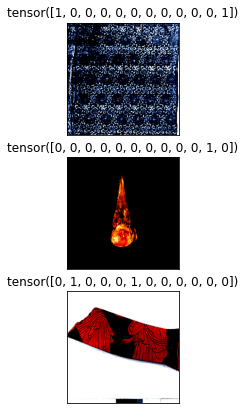

In [22]:
import torch

from kaggle_imet.data import IMetDM, TORCHVISION_TRAIN_TRANSFORM, TORCHVISION_VALID_TRANSFORM

dm = IMetDM(
    base_path=PATH_DATASET,
    path_csv="train-from-kaggle_min-lb-sample-10000.csv",
    batch_size=228,
    train_transforms=TORCHVISION_TRAIN_TRANSFORM,
    valid_transforms=TORCHVISION_VALID_TRANSFORM,
    # num_workers=0,
)
dm.setup()
print(f"nb labels: {dm.num_classes}")

# Quick view
fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.val_dataloader():
    batch_lb_sum = torch.sum(lbs, axis=0).numpy()
    print(f'batch labels: {list(batch_lb_sum[batch_lb_sum > 0])}')
    print(f'image size: {imgs[0].shape}')
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

## CNN Model

We start with some stanrd CNN models taken from torch vision. Then we define Ligthning module including training and validation step and configure optimizer/schedular.

In [23]:
from kaggle_imet.models import LitResnet, LitMet

# see: https://pytorch.org/vision/stable/models.html
net = LitResnet(arch='resnet50', num_classes=dm.num_classes)
# print(net)

model = LitMet(model=net, lr=5e-4)

## Training

We use Pytorch Lightning which allow us to drop all the boilet plate code and simplify all training just to use/call Trainer...

In [ ]:
import pytorch_lightning as pl
print(pl.__version__)

logger = pl.loggers.CSVLogger(save_dir='logs/', name=model.arch)
swa = pl.callbacks.StochasticWeightAveraging(swa_epoch_start=0.6)
ckpt = pl.callbacks.ModelCheckpoint(
    monitor='valid_f1',
    save_top_k=1,
    save_last=True,
    # save_weights_only=True,
    filename='checkpoint/{epoch:02d}-{valid_acc:.4f}-{valid_f1:.4f}',
    # verbose=False,
    mode='max',
)

# ==============================

trainer = pl.Trainer(
    # fast_dev_run=True,
    gpus=1,
    # accelerator='ddp_spawn',
    callbacks=[ckpt, swa],
    logger=logger,
    max_epochs=10,
    precision=16,
    #overfit_batches=5,
    auto_lr_find=True,
    accumulate_grad_batches=24,
    val_check_interval=0.25,
    progress_bar_refresh_rate=1,
    weights_summary='top',
)

# ==============================

# lr_find_kwargs = dict(min_lr=1e-5, max_lr=1e-2, num_training=25)
# trainer.tune(model, datamodule=dm, lr_find_kwargs=lr_find_kwargs)
# print(f"LR: {model.learning_rate}")

# ==============================

trainer.fit(model=model, datamodule=dm)

Quick visualization of the training process...

   valid_loss  valid_acc  valid_prec  ...  train_acc  train_prec  train_f1
0    0.717675   0.883878    0.609302  ...        NaN         NaN       NaN
1    0.690317   0.887064    0.629299  ...        NaN         NaN       NaN
2    0.685983   0.890867    0.641308  ...        NaN         NaN       NaN
3    0.683957   0.892695    0.753844  ...        NaN         NaN       NaN
4    0.683594   0.893792    0.742572  ...        NaN         NaN       NaN

[5 rows x 10 columns]


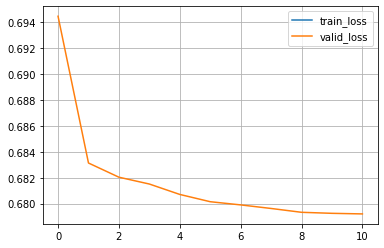

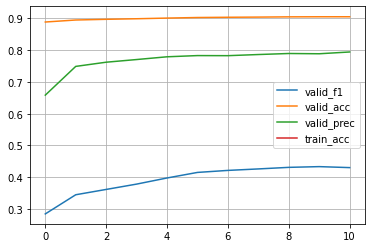

In [25]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
print(metrics.head())

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[['train_loss', 'valid_loss']].plot(grid=True, legend=True)
df_metrics[['valid_f1', 'valid_acc', 'valid_prec', 'train_acc']].plot(grid=True, legend=True)

## Predictions

In [ ]:
import os
import tqdm

preds = []
dm.batch_size = 128
model.cuda().eval()

pbar = tqdm.tqdm(total=len(dm.test_dataset))
for imgs, names in dm.test_dataloader():
    with torch.no_grad():
        onehots = model(imgs.cuda()).cpu()
    # print(np.round(onehots.detach().numpy(), decimals=2))
    for oh, name in zip(onehots, names):
        lbs = dm.onehot_to_labels(oh)
        preds.append({'id': os.path.splitext(name)[0], 'attribute_ids': " ".join(lbs)})
    # break
    pbar.update(len(names))

df_preds = pd.DataFrame(preds)
print(df_preds.head())
print(len(df_preds))
df_preds.to_csv('submission.csv', index=False)

In [29]:
# df_preds = pd.DataFrame(preds)
df_base = pd.DataFrame(dm.test_table)
df_base['id'] = [os.path.splitext(n)[0] for n in df_base['id']]

_preds = list(df_preds)
missing = [{'id': n, 'attribute_ids': ""} for n in df_base['id'] if n not in _preds]
print(f"found missing: {len(missing)}")
df_result = pd.merge(df_preds, pd.DataFrame(missing), how="outer")
df_result.drop_duplicates(subset=['id'], inplace=True)
print(df_result.head())
print(len(df_result))
df_result.to_csv('submission2.csv', index=False)

found missing: 53111
                                 id attribute_ids
0  60aeccd10eadfff8b177ebfcd500ec32           448
1  d8e16ea64b0b10d43146e579badd7e51          2635
2  551575f20ae13cd923a03ed470b52dc0           781
3  8d19eb8b3b51608f3dfc73f30f3504a9          2299
4  4fdf2b57cbee3998c7ad6ca2eaac511d           448
53111


### Save with plain PyTorch

In [30]:
torch.save(model.model, f'fgvc8_{net.arch}.pt')

net2 = torch.load(f'fgvc8_{net.arch}.pt')
model2 = LitMet(model=net2)

In [31]:
preds = []
model2.cpu().eval()

for imgs, names in dm.test_dataloader():
    with torch.no_grad():
        onehots = model2(imgs).cpu()
    print(np.round(onehots.detach().numpy(), decimals=2))
    break









100%|██████████| 53110/53110 [11:17<00:00, 123.73it/s]

[[0.34 0.   0.12 ... 0.   0.   0.  ]
 [0.   0.   0.04 ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   1.   ... 0.   0.   0.  ]
 [0.   0.01 0.   ... 0.   0.   0.  ]]
